# Метод ближайших соседей (k-Nearest Neighbor, kNN) 

*Выполните приведенный код и задания.*

Создание классификатора kNN включает два этапа:

- Во время обучения классификатор берет обучающие данные и просто запоминает их
- Во время тестирования kNN классифицирует каждое тестовое изображение, сравнивая его со всеми обучающими изображениями и передавая метки k наиболее похожих обучающих примеров

Значение k проходит перекрестную проверку (cross-validation)

В этом упражнении вы выполните эти шаги и поймете основны классификации изображений, перекрестную проверку и приобретете навыки написания эффективного векторизованного кода.

### 1. Импорт необходимых библиотек. Если некоторые из них отстутствуют у вас в системе - установите их командой pip install

In [3]:
import random
import os
import platform
from six.moves import cPickle as pickle
import numpy as np
import matplotlib.pyplot as plt

### 2. Настройка параметров отображения для pyplot

In [4]:
# magic-команда для отображения графиков внутри окна
%matplotlib inline
# Размеры графиков и параметры по умолчанию
plt.rcParams['figure.figsize'] = (10.0, 8.0) 
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# Автоматическая перезагрузка кода при изменении. Подробнее о функции:
# http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

### 3. Функции для загрузки датасета
Набор данных в этот раз включает в себя цветные изображения 32х32 пикселя, упакованные в наборы (batch). Изображения упакованы в виде набора байт (pickle) и при загрузке должны быть преобразованы с помощью одноименной библиотеки. Таким образом, для загрузки датасета должна быть вызвана функция load_CIFAR10, приведенная в этом блоке. Она возвращает 4 массива - тренировочный и проверочный наборы данных и 2 массива меток для этих данных

In [5]:
def load_CIFAR_batch(filename):
    """ load single batch of cifar """
    with open(filename, "rb") as f:
        datadict = load_pickle(f)
        X = datadict["data"]
        Y = datadict["labels"]
        X = X.reshape(10000, 3, 32, 32).transpose(0, 2, 3, 1).astype("float")
        Y = np.array(Y)
        return X, Y

def load_pickle(f):
    version = platform.python_version_tuple()
    if version[0] == "2":
        return pickle.load(f)
    elif version[0] == "3":
        return pickle.load(f, encoding="latin1")
    raise ValueError("invalid python version: {}".format(version))
    
    
def load_CIFAR10(ROOT):
    """ load all of cifar """
    xs = []
    ys = []
    for b in range(1, 6):
        f = os.path.join(ROOT, "data_batch_%d" % (b,))
        X, Y = load_CIFAR_batch(f)
        xs.append(X)
        ys.append(Y)
    Xtr = np.concatenate(xs)
    Ytr = np.concatenate(ys)
    del X, Y
    Xte, Yte = load_CIFAR_batch(os.path.join(ROOT, "test_batch"))
    return Xtr, Ytr, Xte, Yte

### 4. В этом блоке указывается путь к файлам набора данных и происходит их загрузка

In [6]:
# Относительный путь к набору данных
cifar10_dir = 'cifar-10-batches-py'

# Очищаем массивы переменных на случай если они не пустые 
try:
   del X_train, y_train
   del X_test, y_test
   print('Clear previously loaded data.')
except:
   pass

# Загружаем набор данных с помощью описанных выше функций
X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)

# Проверка, выводим размерность полученных массивов
print('Training data shape: ', X_train.shape)
print('Training labels shape: ', y_train.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)

Training data shape:  (50000, 32, 32, 3)
Training labels shape:  (50000,)
Test data shape:  (10000, 32, 32, 3)
Test labels shape:  (10000,)


### 5. Визуализируем примеры картинок для каждого из 10 классов

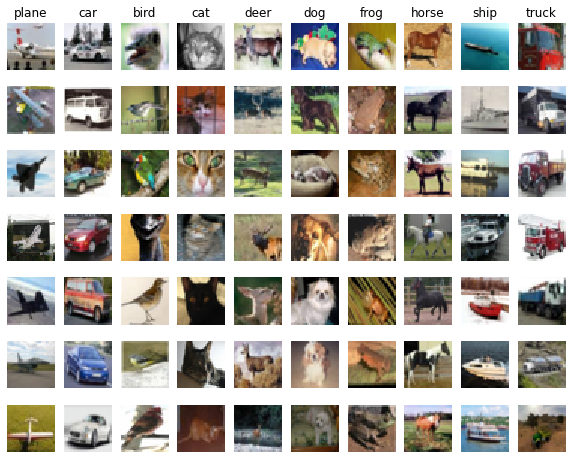

In [7]:
# Массив имен классов
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
#Число классов определяется по числу записей в массиве
num_classes = len(classes)
#Количество примеров для каждого класса
samples_per_class = 7
for y, cls in enumerate(classes):
    idxs = np.flatnonzero(y_train == y)
    #Случайный выбор из массива
    idxs = np.random.choice(idxs, samples_per_class, replace=False)
    for i, idx in enumerate(idxs):
        plt_idx = i * num_classes + y + 1
        plt.subplot(samples_per_class, num_classes, plt_idx)
        plt.imshow(X_train[idx].astype('uint8'))
        plt.axis('off')
        if i == 0:
            #Заголовок для столбца
            plt.title(cls)
plt.show()

### 6. Уменьшаем наборы данных в 10 раз для сокращения времени работы и экономии ресурсов
После чего преобразовываем массивы 5000х32х32х3 и 500х32х32х3 в 5000х3072 и 500х3072 соответственно

In [8]:
num_training = 5000
mask = list(range(num_training))
X_train = X_train[mask]
y_train = y_train[mask]

num_test = 500
mask = list(range(num_test))
X_test = X_test[mask]
y_test = y_test[mask]

X_train = np.reshape(X_train, (X_train.shape[0], -1))
X_test = np.reshape(X_test, (X_test.shape[0], -1))
print(X_train.shape, X_test.shape)

(5000, 3072) (500, 3072)


## 7. Класс kNN классификатора
В приведенном виде классификатор неработоспособен. Ваша задача - дополнить функции для обеспечения функциональности. 
Указания по написанию кода классификатора вы найдете в текстовых блоках ниже. Вам придется возвращаться к этому блоку несколько раз. Каждый раз после изменения кода необходимо выполнить этот блок, заново создать классификатор (выполнить блок 8), а так же выполнить необходимые блоки кода (расчет расстояний и т. п.)

In [9]:
from math import sqrt
from sklearn.neighbors import KNeighborsClassifier

class KNearestNeighbor(object):
    """ kNN классификатор с Евклидовым расстоянием """

    def __init__(self):
        pass

    def train(self, X, y):
        """
        Функция обучения модели
        Для kNN классификатора - просто запоминаем тренировочный набор данных

        Входные:
        - X: Массив numpy размерности (num_train, D) содержащий тренировочный набор данных
          состоящий из num_train записей размерности D.
        - y: Массив numpy размерности (N,) одержащий метки для тренировочного набора данных, где
             y[i] это метка для X[i].
        """
        self.X_train = X
        self.y_train = y

    def predict(self, X, k=1, num_loops=0):
        """
        Функция предсказания меток для тестового набора данных

        Входные:
        - X: Массив numpy размерности (num_train, D) содержащий тестовый набор данных, 
             включающий в себя num_test примеров для каждого измерения D.
        - k: Количество ближайших соседей для определния предсказанных меток.
        - num_loops: Определяет способ реализации определния расстояния между точками - соседями

        Выходные:
        - y: Массив numpy размерности (num_test,) содержаций предсказанные метки для 
          тестовых данных, где y[i] предсказанная метка класса для X[i].
        """
        if num_loops == 0:
            dists = self.compute_distances_no_loops(X)
        elif num_loops == 1:
            dists = self.compute_distances_one_loop(X)
        elif num_loops == 2:
            dists = self.compute_distances_two_loops(X)
        else:
            raise ValueError("Invalid value %d for num_loops" % num_loops)

        return self.predict_labels(dists, k=k)

    def compute_distances_two_loops(self, X):
        """
        Функция расчета расстояния между каждой точкой массива X и каждой точкой 
        массива self.X_train, использующая вложенный цикл по тренировочным и 
        проверочным данным

        Входные:
        - X: Массив numpy размерности (num_train, D) содержащий тестовый набор данных.

        Выходные:
        - dists: Массив numpy размерности (num_test, num_train), где dists[i, j] - это
          Евклидово расстояние между i-той тестовой и j-той проверочной точками

        """
        num_test = X.shape[0]
        num_train = self.X_train.shape[0]
        dists = np.zeros((num_test, num_train))
        for i in range(num_test):
            for j in range(num_train):
                #####################################################################
                #                                                                   #
                #                       ЗАДАНИЕ 1                                   #
                #                                                                   #
                # Расчитайте Евклидово расстояние между i-той тестовой и            #
                # j-той тренировочной точками и сохрание результат в dists[i, j]    #
                # Помните, использование других циклов и np.linalg.norm() нельзя!   #
                #####################################################################
                
                # *****           ВАШ КОД НИЖЕ ЭТОЙ ЛИНИИ                       *****
                
                dists[i, j] = sqrt(np.sum((X[i, :] - self.X_train[j, :]) ** 2))

                # *****           ВАШ КОД ВЫШЕ ЭТОЙ ЛИНИИ                       *****
        return dists

    def compute_distances_one_loop(self, X):
        """
        Функция расчета расстояния между каждой точкой массива X и каждой точкой 
        массива self.X_train, использующая одиночный цикл по массиву проверочных данных.

        Входные/Выходные: Аналогичны функции compute_distances_two_loops
        """
        num_test = X.shape[0]
        num_train = self.X_train.shape[0]
        dists = np.zeros((num_test, num_train))
        for i in range(num_test):
            #####################################################################
            #                                                                   #
            #                       ЗАДАНИЕ 3                                   #
            #                                                                   #
            # Расчитайте Евклидово расстояние между i-той тестовой и            #
            # всеми тренировочной точками и сохрание результат в dists[i, :]    #
            # Помните, использовать np.linalg.norm() нельзя!                    #
            #####################################################################
            # *****           ВАШ КОД НИЖЕ ЭТОЙ ЛИНИИ                       *****

            dists[i, :] = np.sqrt(np.sum(np.square(self.X_train - X[i, :]), axis=1))

            # *****           ВАШ КОД ВЫШЕ ЭТОЙ ЛИНИИ                       *****
        return dists

    def compute_distances_no_loops(self, X):
        """
        Функция расчета расстояния между каждой точкой массива X и каждой точкой 
        массива self.X_train, не использующая циклов.

        Входные/Выходные: Аналогичны функции compute_distances_two_loops
        """
        num_test = X.shape[0]
        num_train = self.X_train.shape[0]
        dists = np.zeros((num_test, num_train))
        #####################################################################
        #                                                                   #
        #                       ЗАДАНИЕ 4                                   #
        #                                                                   #
        # Расчитайте Евклидово расстояние между всеми тестовыми и           #
        # всеми тренировочными точками без использования циклов.            #
        # Используйте базовые операции над массивами                        #
        # Помните, использовать np.linalg.norm() все еще нельзя! 
        # HINT: Попробуйте сформулировать расстояние l2, используя матричное#
        # умножение и две широковещательные суммы.                          #
        #####################################################################
        # *****           ВАШ КОД НИЖЕ ЭТОЙ ЛИНИИ                       *****

        sx = np.sum(X**2, axis=1, keepdims=True)
        sy = np.sum(self.X_train**2, axis=1, keepdims=True)
        dists = np.sqrt(-2 * X.dot(self.X_train.T) + sx + sy.T)

        # *****           ВАШ КОД ВЫШЕ ЭТОЙ ЛИНИИ                       *****
        return dists

    def predict_labels(self, dists, k=1):
        """
        Given a matrix of distances between test points and training points,
        predict a label for each test point.

        Inputs:
        - dists: A numpy array of shape (num_test, num_train) where dists[i, j]
          gives the distance betwen the ith test point and the jth training point.

        Returns:
        - y: A numpy array of shape (num_test,) containing predicted labels for the
          test data, where y[i] is the predicted label for the test point X[i].
        """
        num_test = dists.shape[0]
        y_pred = np.zeros(num_test)
        for i in range(num_test):
            # Массив, содержащий метки k ближайших соседей к 
            # i-той точке
            closest_y = []
            #####################################################################
            #                                                                   #
            #                       ЗАДАНИЕ 2                                   #
            #                                                                   #
            # Используйте матрицу расстояний, чтобы найти k ближайших соседей   #
            # к i-той тестовой точке. testing point, и используйте self.y_train #
            # чтобы найти метки этих соседей. Сохраните метки в  closest_y.     #
            # Hint: См. функцию numpy.argsort.                                  #
            #####################################################################
            # *****           ВАШ КОД НИЖЕ ЭТОЙ ЛИНИИ                       *****
            y_indicles = np.argsort(dists[i, :], axis = 0)
            closest_y = self.y_train[y_indicles[:k]]

            # *****           ВАШ КОД ВЫШЕ ЭТОЙ ЛИНИИ                       *****
            #####################################################################
            #                                                                   #
            #                       ЗАДАНИЕ 2                                   #
            #                                                                   #
            # Теперь, когда найдены метки k ближайших соседей, необходимо       #
            # найти наиболее часто встречающуюся метку в списке  сlosest_y      #
            # Сохраните эту метку в y_pred[i].                                  #
            #####################################################################
            # *****           ВАШ КОД НИЖЕ ЭТОЙ ЛИНИИ                       *****

            y_pred[i] = np.argmax(np.bincount(closest_y))

            # *****           ВАШ КОД ВЫШЕ ЭТОЙ ЛИНИИ                       *****

        return y_pred

### 8. Создаем экземпляр класса классификатора. 
И "тренируем" его. Помните, в процессе "обучения", kNN классификатор просто запоминает данные  без какой-либо их обработки

In [10]:
classifier = KNearestNeighbor()
classifier.train(X_train, y_train)

### 9. Задание 1
Теперь мы можем попытаться классифицировать наши данные при помощи kNN классификатора. 
Как говорилось ранее, этот процесс разделяется на 2 этапа: 

1. Сначала мы должны определить расстояния между всеми тестовыми и всеми тренировочными элеменами массива. 
2. Далее, с учетом этих расстояний, для каждого элемента проверочного массива мы находим k ближайших соседей,которые и определяют искомую метку.

Начнем с вычисления матрицы расстояний между всеми обучающими и проверочными примерами. Например, если есть **Ntr** обучающих примеров и **Nte** тестовых примеров, на этом этапе должна получиться матрица **Nte x Ntr**, где каждый элемент (i,j) представляет собой расстояние между i-ым тестовым и j-ым проверочным элементом. 

Евклидово расстояние определяется по формуле:
\begin{gather*}
d_2 (I_1, I_2) = \sqrt{\sum{} \left( I_1 - I_2 \right)^2}
\end{gather*}

**Примечание: Для определения расстояния в этом задании нельзя использовать функцию np.linalg.norm()**

**Задание:** Вернтесь к блоку 7 и дополните функцию `compute_distances_two_loops` которая использует (весьма неэффективный) двойной цикл для расчета расстояний между элементами матриц (test, train) и вычисляет одно расстояние да один раз.
После этого выполните блок кода ниже, для того, чтобы получить массив dists размера (num_test, num_training)

In [11]:
dists = classifier.compute_distances_two_loops(X_test)
print(dists.shape)

(500, 5000)


### 10. Визуализируем полученную матрицу расстояний. 
Каждая строка - один проверочный пример, каждый пиксель этой строки - расстояние до одного из тренировочных примеров.

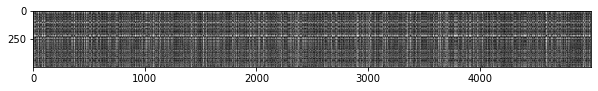

In [12]:
plt.imshow(dists, interpolation='none')
plt.show()

**Вопрос 1** 

На визуализации матрицы расстояний можно заметить цветовые структуры в виде вертикальных и горизонтальных полос. 

(По умолчанию черный цвет означает малое расстояние, а белый - большое.)

- Что в данных является причиной отчетливо ярких строк, а что столбцов?

$\color{blue}{\textit Ответ:}$ Шум



## 11.  Задание 2
Проверим работу модели на тестовых данных.
Примем в этом примере число соседей k = 1

**Задание:** Вернтесь к блоку 7 и дополните функцию `predict_labels` в соответствии с комментариями, приведенными в коде
В результате вы должны получить точность порядка `27%`


In [13]:
y_test_pred = classifier.predict_labels(dists, k=1)

# Определим количество правильных ответов модели и точноть (accuracy)
num_correct = np.sum(y_test_pred == y_test)
accuracy = float(num_correct) / num_test
print('Получено %d из %d правильных => accuracy: %f' % (num_correct, num_test, accuracy))

Получено 137 из 500 правильных => accuracy: 0.274000


### 12. Попробуем принять число соседей k = 5.
В результате должны увидеть точноть немного выше, чем при k = 1

In [14]:
y_test_pred = classifier.predict_labels(dists, k=5)
num_correct = np.sum(y_test_pred == y_test)
accuracy = float(num_correct) / num_test
print('Получено %d из %d правильных => accuracy: %f' % (num_correct, num_test, accuracy))

Получено 139 из 500 правильных => accuracy: 0.278000


**Вопрос 2**

Мы можем использовать другую метрику расстояния, например L1, для значения пикселя $p_{ij}^{(k)}$ с координатами $(i,j)$ в изображении $I_k$, 

Среднее $\mu$ по всем пикселям всех изображений $$\mu=\frac{1}{nhw}\sum_{k=1}^n\sum_{i=1}^{h}\sum_{j=1}^{w}p_{ij}^{(k)}$$
И среднее по пикселям $\mu_{ij}$ по всему изображению 
$$\mu_{ij}=\frac{1}{n}\sum_{k=1}^np_{ij}^{(k)}.$$

Общее стандартное отклонение $\sigma$ и попиксельное стандартное отклонение $\sigma_{ij}$ определяются одинаково.
Какой (какие) из предлагаемых шагов предварительной обработки не изменят эффективность kNN классификатора, использующего L1 расстояние?  
1. Вычтание среднего $\mu$ ($\tilde{p}_{ij}^{(k)}=p_{ij}^{(k)}-\mu$.)
2. Вычитание попиксельного среднего $\mu_{ij}$  ($\tilde{p}_{ij}^{(k)}=p_{ij}^{(k)}-\mu_{ij}$.)
3. Вычтание среднего $\mu$ и деление на стандартное отклонение $\sigma$.
4. Вычитание попиксельного среднего $\mu_{ij}$ и деление на попиксельное стандартное отклонение $\sigma_{ij}$.
5. Врещение координатных осей изображения.

$\color{blue}{\textit Ответ:}$ 1 и 3


$\color{blue}{\textit Комментарии:}$ *Впишите здесь*


## 13. Задание 3

Попробуем увеличить производительность вычисления матрицы расстояний с использованием частичной векторизации и одного цикла для расчета расстояний

**Задание:** Вернитесь к блоку 7 и дополните функцию `compute_distances_one_loop` и запустите следующий блок кода.

 
Чтобы убедиться, что ваша реализация вкторного расстояния верна, сравним 2 массива расстояний. Есть множество способов сравнить матрицы, один из них - норма Фробениуса:
$${\mid \mid A \mid \mid}_F=\sqrt{\sum_{i=1}^n \sum_{j=1}^m \mid a_{ij} \mid^2} $$
Норма Фробениуса двух матриц — это квадратный корень из квадрата суммы разностей всех элементов; другими словами, евклидово расстояние между векторизованными матрицами.

In [15]:
dists_one = classifier.compute_distances_one_loop(X_test)

difference = np.linalg.norm(dists - dists_one, ord='fro')
print('Разница в расстояниях: %f' % (difference, ))
if difference < 0.001:
    print('Матрицы одинаковые')
else:
    print('Матрицы отличаются. Где-то ошибка')

Разница в расстояниях: 0.000000
Матрицы одинаковые


## 14. Задание 4
Пришло время реализовать полностью векторную версию функции вычисления расстояний.

**Задание:** Вернитесь к блоку 7 и дполните функцию `compute_distances_no_loops`

Запустите код ниже и убедитесь, то матрицы расстояний совпадают

In [16]:
dists_two = classifier.compute_distances_no_loops(X_test)


difference = np.linalg.norm(dists - dists_two, ord='fro')
print('Разница в расстояниях: %f' % (difference, ))
if difference < 0.001:
    print('Матрицы одинаковые')
else:
    print('Матрицы отличаются. Где-то ошибка')

Разница в расстояниях: 0.000000
Матрицы одинаковые


### 15. Сравним производительность трех вариантов расчета расстояния.
Для этого используем функцию `time_function`, приведенную ниже. Она позволяет определить время выполнения любой заданной операции.

Предполагается, что мы должны увидеть существенный выигрыш во времени для функции без циклов.

Однако, в зависимости от аппаратной конфигурации, прирост производительности может быть небольшим, и фунция compute_distances_no_loops может даже работать медленнее. На Intel Core i3 4010U именно так и было. На Xeon E5 1650 были получены следующие результаты:
- Версия с двумя циклами 59.169484 с
- Версия с одним циклом 63.031207 с
- Версия без циклов 0.285995 с

In [17]:
def time_function(f, *args):
    """
    Вызывает функцию f с рагументами args и возвращает время (в секундах), которое потребовалось на выполнение.
    """
    import time
    tic = time.time()
    f(*args)
    toc = time.time()
    return toc - tic

two_loop_time = time_function(classifier.compute_distances_two_loops, X_test)
print('Версия с двумя циклами %f с' % two_loop_time)

one_loop_time = time_function(classifier.compute_distances_one_loop, X_test)
print('Версия с одним циклом %f с' % one_loop_time)

no_loop_time = time_function(classifier.compute_distances_no_loops, X_test)
print('Версия без циклов %f с' % no_loop_time)

Версия с двумя циклами 27.553981 с
Версия с одним циклом 61.228873 с
Версия без циклов 0.267006 с


### 16. Задание 5. Кросс-валидация

Мы реализовали kNN классификатор, но значение k = 5 было выбрано произвольно. Теперь мы определим оптимальное значение этого гиперпараметра с использованием кросс-валидации.

**Задание:** Дополните код в блоке ниже в соотвтетвии с комментариями

In [18]:
#Количество блоков данных
num_folds = 5

#Массив значений k
k_choices = [1, 3, 5, 8, 10, 12, 15, 20, 50, 100]

X_train_folds = []
y_train_folds = []
################################################################################
#                                                                              #
# Разделите тренировочный массив на блоки. После разделения X_train_folds и    #
# y_train_folds должны быть спискапи из num_folds записей, где                 #
# y_train_folds[i] метки для элементов в X_train_folds[i].                     #
# Hint: См. функцию array_split                                                #
################################################################################
# *****                ВАШ КОД НИЖЕ ЭТОЙ ЛИНИИ                             *****

# X_train_folds = np.split(X_train, num_folds)
# y_train_folds = np.split(X_train, num_folds)

idxes = range(num_training)
idx_folds = np.array_split(idxes, num_folds)
for idx in idx_folds:
    X_train_folds.append( X_train[idx] )
    y_train_folds.append( y_train[idx] )

# *****                ВАШ КОД ВЫШЕ ЭТОЙ ЛИНИИ                             *****

# Список полученных значений точностиry для различных k.
# После кросс-валидации k_to_accuracies[k] должно быть списком из num_folds записей
# в которых записаны значения точности, найденные для этого k
k_to_accuracies = {}


################################################################################
#                                                                              #
# Примените k-кратную кросс-валидацию для нахождения лучшего значения k.       #
# Для каждого k из списка k_choices выполните алгоритм kNN num_folds раз.      #
# В каждом из случаев вы используете все блоки, кроме одного как тренировочные #
# данные, а последний блок как проверочный. Сохраните значения точности для    #
# всех блоков и все значения k в массиве k_to_accuracies                       #
################################################################################
# *****                ВАШ КОД НИЖЕ ЭТОЙ ЛИНИИ                             *****

import sys
Verbose = False
for k in k_choices:
    k_to_accuracies[k] = list()
    for num in range(num_folds):
            
        X_cv_train = np.vstack( [ X_train_folds[x] for x in range(num_folds) if x != num ])
        y_cv_train = np.hstack( [ y_train_folds[x].T for x in range(num_folds) if x != num ])
            
        X_cv_test = X_train_folds[num]
        y_cv_test = y_train_folds[num]

        classifier.train(X_cv_train, y_cv_train)
            
        dists = classifier.compute_distances_no_loops(X_cv_test)
            
        y_cv_test_pred = classifier.predict_labels(dists, k=k)
        num_correct = np.sum(y_cv_test_pred == y_cv_test)
        k_to_accuracies[k].append( float(num_correct) / y_cv_test.shape[0] )

# *****                ВАШ КОД ВЫШЕ ЭТОЙ ЛИНИИ                             *****

# Печать полученных значений точности для разных k
for k in sorted(k_to_accuracies):
    for accuracy in k_to_accuracies[k]:
        print('k = %d, accuracy = %f' % (k, accuracy))

k = 1, accuracy = 0.263000
k = 1, accuracy = 0.257000
k = 1, accuracy = 0.264000
k = 1, accuracy = 0.278000
k = 1, accuracy = 0.266000
k = 3, accuracy = 0.239000
k = 3, accuracy = 0.249000
k = 3, accuracy = 0.240000
k = 3, accuracy = 0.266000
k = 3, accuracy = 0.254000
k = 5, accuracy = 0.248000
k = 5, accuracy = 0.266000
k = 5, accuracy = 0.280000
k = 5, accuracy = 0.292000
k = 5, accuracy = 0.280000
k = 8, accuracy = 0.262000
k = 8, accuracy = 0.282000
k = 8, accuracy = 0.273000
k = 8, accuracy = 0.290000
k = 8, accuracy = 0.273000
k = 10, accuracy = 0.265000
k = 10, accuracy = 0.296000
k = 10, accuracy = 0.276000
k = 10, accuracy = 0.284000
k = 10, accuracy = 0.280000
k = 12, accuracy = 0.260000
k = 12, accuracy = 0.295000
k = 12, accuracy = 0.279000
k = 12, accuracy = 0.283000
k = 12, accuracy = 0.280000
k = 15, accuracy = 0.252000
k = 15, accuracy = 0.289000
k = 15, accuracy = 0.278000
k = 15, accuracy = 0.282000
k = 15, accuracy = 0.274000
k = 20, accuracy = 0.270000
k = 20, accu

### 17. Представим полученные данные в виде графика

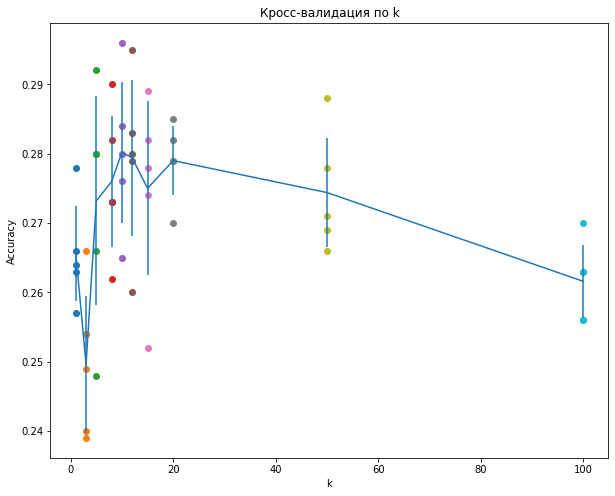

In [19]:
for k in k_choices:
    accuracies = k_to_accuracies[k]
    plt.scatter([k] * len(accuracies), accuracies)

# Вывод линии тренда с планками погрешностей, соответствующими стандартному отклонению
accuracies_mean = np.array([np.mean(v) for k,v in sorted(k_to_accuracies.items())])
accuracies_std = np.array([np.std(v) for k,v in sorted(k_to_accuracies.items())])
plt.errorbar(k_choices, accuracies_mean, yerr=accuracies_std)
plt.title('Кросс-валидация по k')
plt.xlabel('k')
plt.ylabel('Аccuracy')
plt.show()

### 18. Определим достигнутую точность с оптимальным k
На основе результатов выше, повторите расчеты с промужуточными k, не попавшими в первоначальный массив k_choices.
Подставьте выявленное значение оптимального k в блок ниже и запустите код.

Если все сделано правильно, вы должны получить значение accuracy больше 28%

In [20]:
classifier = KNearestNeighbor()
classifier.train(X_train, y_train)

for best_k in range(1, 100):
    y_test_pred = classifier.predict(X_test, k=best_k)

    num_correct = np.sum(y_test_pred == y_test)
    accuracy = float(num_correct) / num_test
    if accuracy > 0.28:
        print('Получено %d из %d правильных => accuracy: %f' % (num_correct, num_test, accuracy))
        print('Best K: %f' % (best_k))

Получено 141 из 500 правильных => accuracy: 0.282000
Best K: 6.000000
Получено 141 из 500 правильных => accuracy: 0.282000
Best K: 10.000000


### 19. Наглядная демонстрация результатов.
Все это время мы работали с изображениями, но не видели самих изображений. Теперь посмотрим визуально чему научилась наша модель. Код ниже выводит 4 картинки из проверочного массива и определенные для них метки.

**Задание:** Дополните блок кода ниже для маркировки правильных и неправильных ответов модели

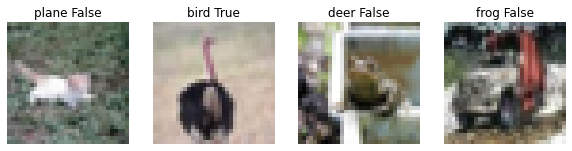

In [21]:
best_k = 6 #Полученный в предыдущем блоке показатель K
y_test_pred = classifier.predict(X_test, k=best_k)

samples = 4
members = np.random.randint(0, num_test, samples)
for i in enumerate(members):
    plt.subplot(1,4,i[0]+1)
    plt.imshow(np.reshape(X_train[i[1]].astype('uint8'),(32,32,3)))
    plt.axis('off')
    TrueOrFalse = ''
    if classes[y_test_pred[i[1]].astype('int')] == classes[y_train[i[1]].astype('int')]:
        TrueOrFalse = 'True'
    else:
        TrueOrFalse = 'False'
    plt.title(classes[y_test_pred[i[1]].astype('int')] + ' ' + TrueOrFalse)
plt.show()

**Вопрос 3**

Какое (какие) из следующих утверждений о $k$-NN классификаторе верны для любого $k$? 
1. Граница решения классификатора k-NN является линейной.
2. Ошибка обучения 1-NN всегда будет меньше или равна ошибке 5-NN.
3. Ошибка теста 1-NN всегда будет ниже, чем у 5-NN.
4. Время, необходимое для классификации тестового примера с помощью классификатора k-NN, растет с увеличением размера обучающей выборки.
5. Ничего из перечисленного.

$\color{blue}{\textit Ответ: }$ 4


$\color{blue}{\textit Объяснение:}$

